In [1]:
import pandas as pd

# Adjust the column list to match your CSV structure
# If there's truly an empty column, you can skip it by specifying usecols.
df = pd.read_csv(
    "forcast/site.csv",
    usecols=[
        "site_key",
        "energy_area",
        "spot_price",
        "site_power",
        "is_holiday",
        "charging_units",
        "total_units",
        "timestamp",
        "value",
    ],
)

# Convert 'timestamp' to a proper datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["hour_of_day"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek

# Sort by site_key then timestamp (just to keep data organized)
df.sort_values(by=["site_key","timestamp"], inplace=True)


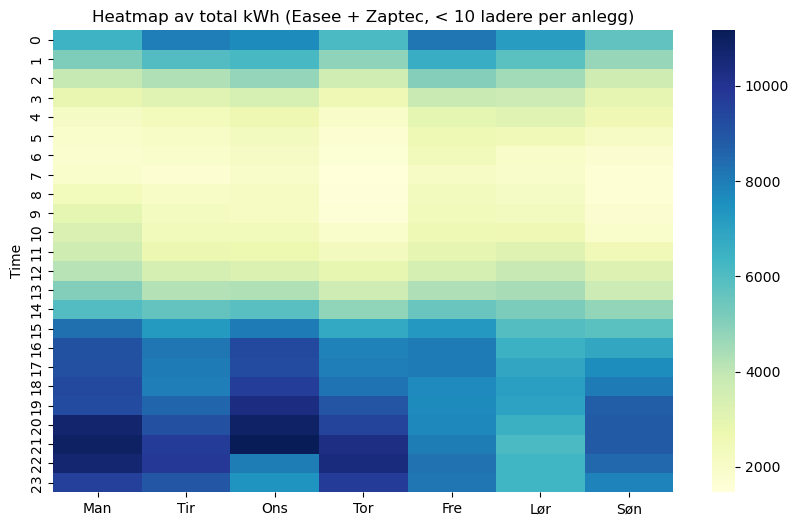

In [2]:
# %% 
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data by hour_of_day and day_of_week and calculate the sum of 'value'
heatmap_data = (
    df.groupby(["hour_of_day", "day_of_week"])["value"]
    .sum()
    .unstack(level="day_of_week")
)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    # annot=True,
    # fmt=".1f",
    cmap="YlGnBu",
    cbar=True,
    xticklabels=["Man", "Tir", "Ons", "Tor", "Fre", "Lør", "Søn"],
    yticklabels=range(24),
)
plt.title("Heatmap av total kWh (Easee + Zaptec, < 10 ladere per anlegg)")
plt.xlabel("")
plt.ylabel("Time")
plt.show()

# %%


In [3]:


# Set a MultiIndex of [site_key, timestamp]
# df.set_index(["site_key", "timestamp"], inplace=True)

# Reset index so site_key and timestamp become columns again
df_ml = df.reset_index()

# Example: create a lag feature (value at T-1)
df_ml["value_lag1"] = df_ml.groupby("site_key")["value"].shift(1)
df_ml["charging_units1"] = df_ml.groupby("site_key")["charging_units"].shift(1)

# Drop rows with NaN from the lag/rolling (or keep them if you have a strategy)
# df_ml.dropna(inplace=True)

# Now split into features vs. target
X = df_ml[
    [
        "site_key",
        "timestamp",
        "spot_price",
        "site_power",
        "total_units",
        "is_holiday",
        # "charging_units1",
        "value_lag1",
    ]
]
        
y_variable = "value"

y = df_ml[y_variable]




In [4]:

# Convert timestamp to numerical features or cyclical time features (hour of day, day of week, etc.)
# Also might need to one-hot encode site_key if you want a single global model.

X_encoded = pd.get_dummies(X, columns=["site_key"])

# Drop or transform actual 'timestamp' as needed (some models can’t use date/time directly).
X_encoded.drop(columns="timestamp", inplace=True)

In [5]:
# After you have X_encoded and y:

from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
# Initialize the TimeSeriesSplit
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Prepare lists to store per-fold metrics
mse_list, mae_list, r2_list = [], [], []

# Create a container to store predictions for each test index
# This series will have the same index as y and initially be NaN.
all_predictions = pd.Series(data=np.nan, index=y.index, name="predictions")

fold_num = 1
for train_index, test_index in tscv.split(X_encoded):
    # Split into train and test
    X_train_cv, X_test_cv = X_encoded.iloc[train_index], X_encoded.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Fit a regressor
    model_cv = XGBRegressor()
    model_cv.fit(X_train_cv, y_train_cv)

    # Predict
    y_pred_cv = model_cv.predict(X_test_cv)

    # Compute metrics
    mse_cv = mean_squared_error(y_test_cv, y_pred_cv)
    mae_cv = mean_absolute_error(y_test_cv, y_pred_cv)
    r2_cv = r2_score(y_test_cv, y_pred_cv)

    mse_list.append(mse_cv)
    mae_list.append(mae_cv)
    r2_list.append(r2_cv)

    print(f"Fold {fold_num} -> Train size: {len(train_index)}, Test size: {len(test_index)}")
    print(f"  MSE: {mse_cv:.3f}, MAE: {mae_cv:.3f}, R^2: {r2_cv:.3f}")
    print("-" * 40)

    # Store the predictions in our container at the correct indices
    all_predictions.iloc[test_index] = y_pred_cv

    fold_num += 1


Fold 1 -> Train size: 90555, Test size: 90552
  MSE: 1.940, MAE: 0.587, R^2: 0.604
----------------------------------------
Fold 2 -> Train size: 181107, Test size: 90552
  MSE: 1.586, MAE: 0.522, R^2: 0.605
----------------------------------------
Fold 3 -> Train size: 271659, Test size: 90552
  MSE: 2.216, MAE: 0.603, R^2: 0.626
----------------------------------------
Fold 4 -> Train size: 362211, Test size: 90552
  MSE: 2.309, MAE: 0.646, R^2: 0.653
----------------------------------------
Fold 5 -> Train size: 452763, Test size: 90552
  MSE: 2.306, MAE: 0.643, R^2: 0.626
----------------------------------------
Fold 6 -> Train size: 543315, Test size: 90552
  MSE: 2.412, MAE: 0.639, R^2: 0.641
----------------------------------------
Fold 7 -> Train size: 633867, Test size: 90552
  MSE: 2.431, MAE: 0.679, R^2: 0.671
----------------------------------------
Fold 8 -> Train size: 724419, Test size: 90552
  MSE: 1.992, MAE: 0.596, R^2: 0.641
----------------------------------------
F

=== Overall Cross-Validation Results ===
Average MSE: 2.128
Average MAE: 0.610
Average R^2: 0.631


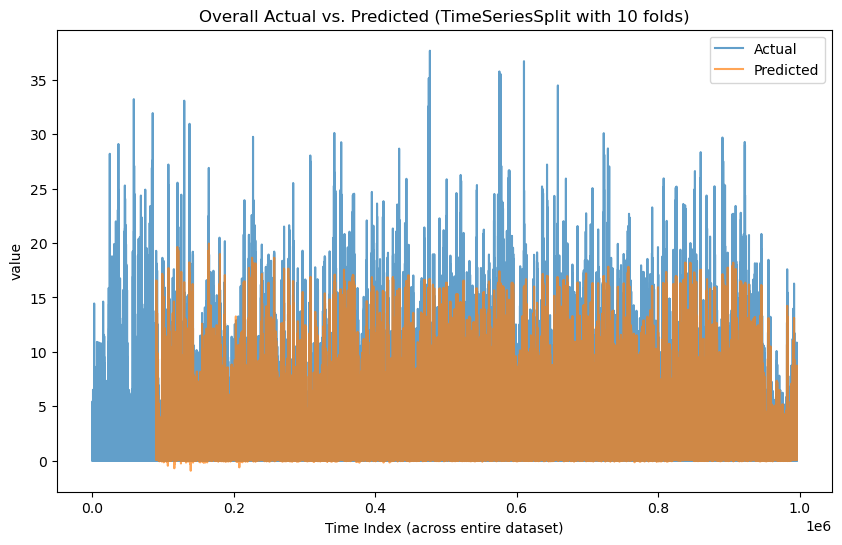

In [6]:

print("=== Overall Cross-Validation Results ===")
print(f"Average MSE: {np.mean(mse_list):.3f}")
print(f"Average MAE: {np.mean(mae_list):.3f}")
print(f"Average R^2: {np.mean(r2_list):.3f}")

plt.figure(figsize=(10, 6))
plt.plot(y.reset_index(drop=True), label="Actual", alpha=0.7)
plt.plot(all_predictions.reset_index(drop=True), label="Predicted", alpha=0.7)
plt.title(f"Overall Actual vs. Predicted (TimeSeriesSplit with {n_splits} folds)")
plt.xlabel("Time Index (across entire dataset)")
plt.ylabel("value")
plt.legend()
plt.show()

In [7]:

# Train/test split (by time or randomly, depending on your scenario)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, shuffle=False, test_size=0.2
)

In [8]:

# Fit a regressor (e.g. XGBoost)
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)

# Future forecasting would require you to create the same feature structure
# (lags, site_key, hour_of_day, etc.) for the future timestamps, then call model.predict(future_features).

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)



MSE:  2.036
MAE:  0.590
R^2:  0.632


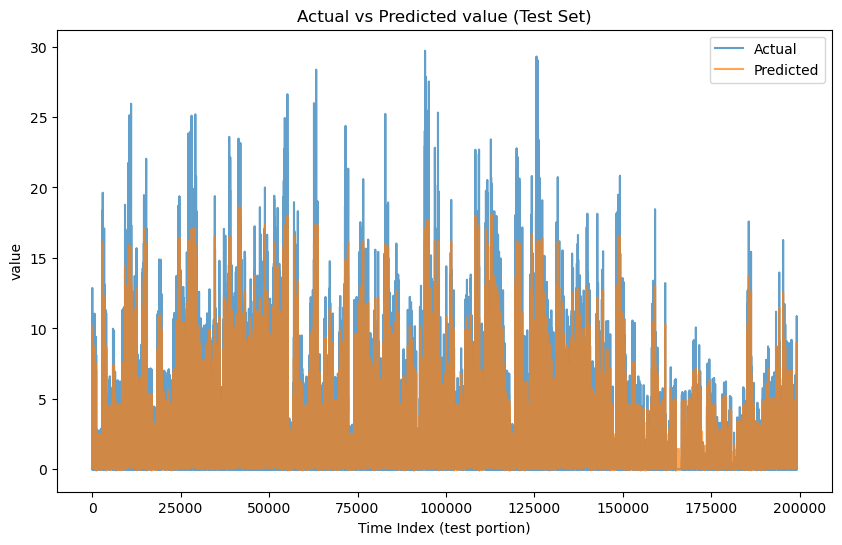

In [10]:

# Reset the index to compare side-by-side (optional)
y_test_reset = y_test.reset_index(drop=True)
y_pred_reset = pd.Series(y_pred)
print(f"MSE:  {mse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R^2:  {r2:.3f}")
plt.figure(figsize=(10,6))
plt.plot(y_test_reset, label='Actual', alpha=0.7)
plt.plot(y_pred_reset, label='Predicted', alpha=0.7)
plt.title(f"Actual vs Predicted {y_variable} (Test Set)")
plt.xlabel("Time Index (test portion)")
plt.ylabel(y_variable)
plt.legend()
plt.show()
